Epoch 1/100
16/16 [==============================] - 4s 75ms/step - loss: 16082976.0000 - mae: 3709.5085 - mse: 16082976.0000 - val_loss: 44494876.0000 - val_mae: 6597.8765 - val_mse: 44494876.0000
Epoch 2/100
16/16 [==============================] - 0s 25ms/step - loss: 15549939.0000 - mae: 3634.7073 - mse: 15549939.0000 - val_loss: 42012952.0000 - val_mae: 6407.0918 - val_mse: 42012948.0000
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 12175343.0000 - mae: 3125.2666 - mse: 12175343.0000 - val_loss: 28665170.0000 - val_mae: 5262.5635 - val_mse: 28665170.0000
Epoch 4/100
16/16 [==============================] - 0s 26ms/step - loss: 4148831.2500 - mae: 1675.8478 - mse: 4148831.2500 - val_loss: 4284540.5000 - val_mae: 1863.3984 - val_mse: 4284540.5000
Epoch 5/100
16/16 [==============================] - 0s 25ms/step - loss: 2251877.0000 - mae: 1185.4630 - mse: 2251877.0000 - val_loss: 6796691.5000 - val_mae: 2431.8586 - val_mse: 6796691.5000
Epoch 6/100
16/16 

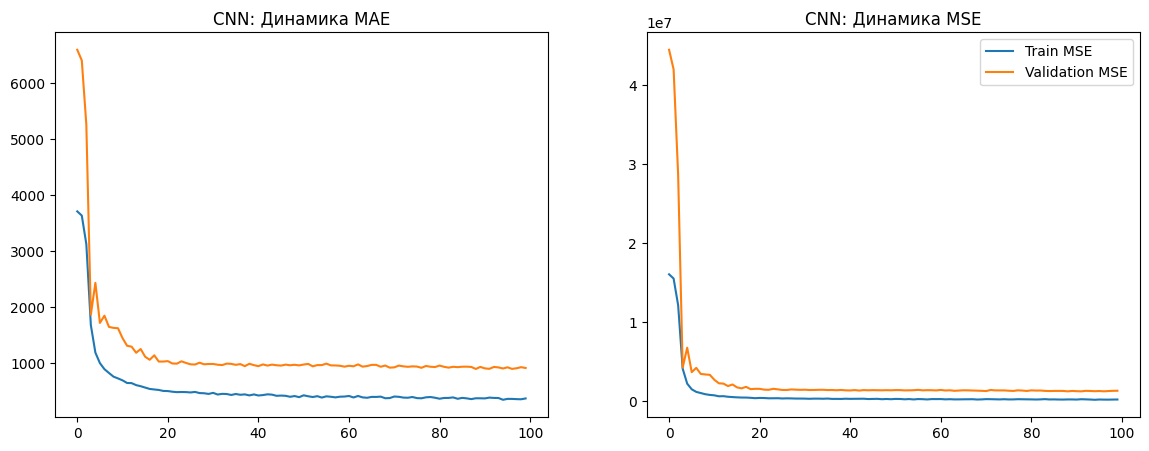

In [7]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, 
                                   Flatten, Dense, Dropout)
from tensorflow.keras.optimizers import Adam

# 1. Загрузка и подготовка данных с временной структурой
df = pd.read_csv('day.csv').sort_values('dteday')

# Обработка признаков (полная)
def cnn_preprocessing(df):
    # Удаление избыточных колонок
    df = df.drop(['instant', 'casual', 'registered'], axis=1)
    
    # Преобразование категориальных признаков
    time_features = ['season', 'mnth', 'weekday', 'weathersit', 'holiday']
    df = pd.get_dummies(df, columns=time_features)
    
    # Сохранение временного порядка
    X = df.drop(['cnt', 'dteday'], axis=1).values
    y = df['cnt'].values
    
    # Нормализация
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Подготовка для Conv1D [samples, timesteps, features]
    X_reshaped = X_scaled.reshape(-1, 1, X_scaled.shape[1])
    
    return X_reshaped, y, scaler

X, y, scaler = cnn_preprocessing(df)

# 2. Временное разделение данных (без перемешивания!)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Архитектура 1D-CNN
model = Sequential([
    Conv1D(64, kernel_size=1, activation='relu', 
          input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=1),
    Conv1D(128, kernel_size=1, activation='relu'),
    Dropout(0.4),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

# 4. Компиляция с тонкой настройкой
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

# 5. Обучение с замером времени
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.15,
    verbose=1
)
training_time = time.time() - start_time

# 6. Оценка и вывод результатов
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=0)

print(f'''
╭{'─'*40}╮
│ Результаты 1D-CNN (100 эпох)        │
├{'─'*40}┤
│ Время обучения: {training_time:.2f} сек       │
│ Тестовый MAE:   {test_mae:.2f}              │
│ Тестовый MSE:   {test_mse:.2f}            │
╰{'─'*40}╯''')

# 7. Визуализация
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('CNN: Динамика MAE')

plt.subplot(1,2,2)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE') 
plt.title('CNN: Динамика MSE')
plt.legend()
plt.show()
